In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Union
import requests
import time
import numpy as np
import re

# Constants
OLLAMA_API = "http://localhost:11434/api/generate"
MODEL_NAME = "phi"

# Load prompts
def load_prompt(filename: str) -> str:
    try:
        with open(f"../prompts/{filename}", "r") as f:
            content = f.read()
            print(f"Successfully loaded {filename}")
            return content
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return ""

# Load test cases
def load_test_cases() -> List[Dict]:
    try:
        with open("../evaluation/input_queries.json", "r") as f:
            data = json.load(f)
            print(f"Successfully loaded {len(data['test_cases'])} test cases")
            return data["test_cases"]
    except Exception as e:
        print(f"Error loading test cases: {e}")
        return []

# Initialize prompt templates
print("\nLoading prompt templates...")
zero_shot_template = load_prompt("zero_shot.txt")
few_shot_template = load_prompt("few_shot.txt")
cot_template = load_prompt("cot_prompt.txt")
meta_template = load_prompt("meta_prompt.txt")



Loading prompt templates...
Successfully loaded zero_shot.txt
Successfully loaded few_shot.txt
Successfully loaded cot_prompt.txt
Successfully loaded meta_prompt.txt


In [2]:
def extract_number(text: str) -> List[float]:
    """Extract numbers from text, handling decimals and negatives."""
    # Pattern matches integers, decimals, and negative numbers
    pattern = r'-?\d*\.?\d+'
    numbers = re.findall(pattern, text)
    return [float(num) for num in numbers if num]

def query_model(prompt: str, max_tokens: int = 1000) -> str:
    """Query the Ollama model with a prompt."""
    data = {
        "model": MODEL_NAME,
        "prompt": prompt,
        "stream": False,
        "max_tokens": max_tokens
    }
    
    try:
        response = requests.post(OLLAMA_API, json=data)
        response.raise_for_status()
        result = response.json()["response"]
        print("\nModel Response:")
        print("-------------")
        print(result[:200] + "..." if len(result) > 200 else result)  # Show first 200 chars
        return result
    except Exception as e:
        print(f"Error querying model: {e}")
        return ""

def evaluate_response(response: str, expected: Union[float, List[float]]) -> Dict:
    """
    Evaluate the model's response against expected answer.
    Returns metrics including accuracy and reasoning quality.
    """
    try:
        # Extract all numbers from response
        numbers = extract_number(response)
        print(f"\nExtracted numbers: {numbers}")
        
        if not numbers:
            print("No numbers found in response")
            return {
                "accuracy": 0,
                "reasoning_quality": 0,
                "response_length": len(response)
            }
        
        if isinstance(expected, list):
            # For problems with multiple answers (like quadratic equations)
            accuracy = all(any(abs(a - e) < 0.1 for e in expected) for a in numbers)
        else:
            # Find the number closest to expected answer
            closest = min(numbers, key=lambda x: abs(x - expected))
            accuracy = abs(closest - expected) < 0.1
            print(f"Closest number to expected {expected}: {closest}")
            
        # Evaluate reasoning quality
        steps = response.split('\n')
        reasoning_score = min(5, len([s for s in steps if s.strip()])) / 5
        
        result = {
            "accuracy": 1 if accuracy else 0,
            "reasoning_quality": reasoning_score,
            "response_length": len(response)
        }
        print(f"Evaluation result: {result}")
        return result
        
    except Exception as e:
        print(f"Error evaluating response: {e}")
        print(f"Response: {response[:100]}...")  # Show first 100 chars of response
        return {
            "accuracy": 0,
            "reasoning_quality": 0,
            "response_length": len(response)
        }


In [3]:
# Run evaluation for each prompt type
def run_evaluation():
    test_cases = load_test_cases()
    results = []
    
    prompt_types = {
        "zero_shot": zero_shot_template,
        "few_shot": few_shot_template,
        "chain_of_thought": cot_template,
        "meta_prompt": meta_template
    }
    
    for case in test_cases:
        print(f"\n{'='*50}")
        print(f"Evaluating problem {case['id']}")
        print(f"Category: {case['category']}")
        print(f"Difficulty: {case['difficulty']}")
        print(f"Problem: {case['problem']}")
        print(f"Expected answer: {case['expected_answer']}")
        print('='*50)
        
        for prompt_type, template in prompt_types.items():
            print(f"\nTrying {prompt_type} prompt...")
            
            # Prepare prompt
            prompt = template.replace("[PROBLEM]", case["problem"])
            
            # Query model
            response = query_model(prompt)
            
            # Evaluate response
            metrics = evaluate_response(response, case["expected_answer"])
            
            # Store results
            result = {
                "problem_id": case["id"],
                "category": case["category"],
                "difficulty": case["difficulty"],
                "prompt_type": prompt_type,
                **metrics
            }
            results.append(result)
            print(f"\nResult for {prompt_type}: {result}")
            
            # Add delay to avoid overwhelming the API
            print("\nWaiting for 1 second before next evaluation...")
            time.sleep(1)
    
    df = pd.DataFrame(results)
    print("\nEvaluation complete! Summary:")
    print(df.groupby('prompt_type')[['accuracy', 'reasoning_quality']].mean())
    return df

# Run evaluation
print("Starting evaluation...")
results_df = run_evaluation()


Starting evaluation...
Successfully loaded 8 test cases

Evaluating problem 1
Category: arithmetic
Difficulty: easy
Problem: A store offers a 25% discount on a $120 jacket. What is the final price?
Expected answer: 90.0

Trying zero_shot prompt...

Model Response:
-------------
 Problem Type: Percentage Discount
Key Concepts: Finding the discounted price and using percentage calculations
Solution Steps:
1. Calculate the amount of the discount by multiplying $120 by 25%. This...

Extracted numbers: [1.0, 120.0, 25.0, 30.0, 2.0, 120.0, 30.0, 90.0, 25.0, 90.0, 30.0, 120.0, 36.0, 25.0, 120.0, 36.0, 120.0, 84.0]
Closest number to expected 90.0: 90.0
Evaluation result: {'accuracy': 1, 'reasoning_quality': 1.0, 'response_length': 763}

Result for zero_shot: {'problem_id': 1, 'category': 'arithmetic', 'difficulty': 'easy', 'prompt_type': 'zero_shot', 'accuracy': 1, 'reasoning_quality': 1.0, 'response_length': 763}

Waiting for 1 second before next evaluation...

Trying few_shot prompt...

Mode


Generating visualization plots...


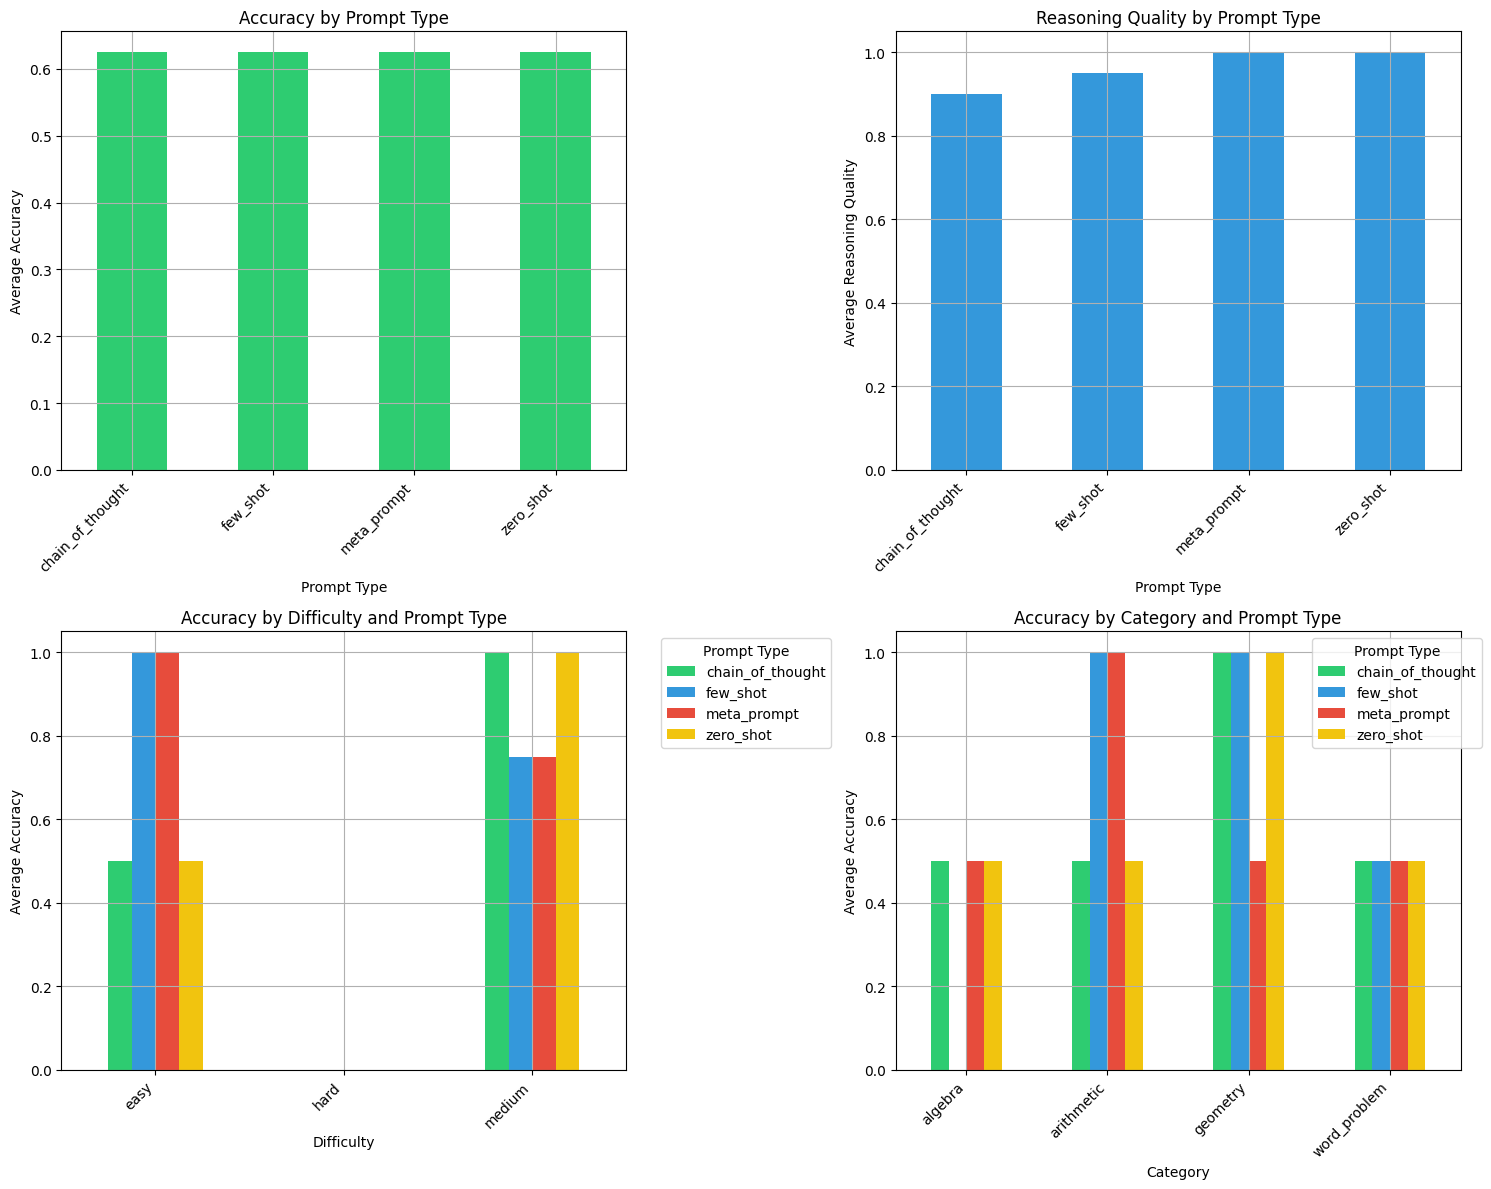


Detailed Statistics:

1. Overall Performance by Prompt Type:
                  accuracy  reasoning_quality
prompt_type                                  
chain_of_thought     0.625               0.90
few_shot             0.625               0.95
meta_prompt          0.625               1.00
zero_shot            0.625               1.00

2. Performance by Difficulty Level:
                    accuracy                                reasoning_quality  \
prompt_type chain_of_thought few_shot meta_prompt zero_shot  chain_of_thought   
difficulty                                                                      
easy                     0.5     1.00        1.00       0.5              0.90   
hard                     0.0     0.00        0.00       0.0              1.00   
medium                   1.0     0.75        0.75       1.0              0.85   

                                            
prompt_type few_shot meta_prompt zero_shot  
difficulty                                  
eas

In [5]:
# Analyze results
def plot_results(df: pd.DataFrame):
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Set a basic style
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True
    
    # Custom colors for better visibility
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']
    
    # 1. Accuracy by prompt type
    ax1 = axes[0,0]
    df.groupby('prompt_type')['accuracy'].mean().plot(
        kind='bar',
        ax=ax1,
        color=colors[0]
    )
    ax1.set_title('Accuracy by Prompt Type')
    ax1.set_xlabel('Prompt Type')
    ax1.set_ylabel('Average Accuracy')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 2. Reasoning quality by prompt type
    ax2 = axes[0,1]
    df.groupby('prompt_type')['reasoning_quality'].mean().plot(
        kind='bar',
        ax=ax2,
        color=colors[1]
    )
    ax2.set_title('Reasoning Quality by Prompt Type')
    ax2.set_xlabel('Prompt Type')
    ax2.set_ylabel('Average Reasoning Quality')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 3. Accuracy by difficulty
    ax3 = axes[1,0]
    pivot_diff = df.pivot_table(
        values='accuracy',
        index='difficulty',
        columns='prompt_type',
        aggfunc='mean'
    )
    pivot_diff.plot(kind='bar', ax=ax3, color=colors)
    ax3.set_title('Accuracy by Difficulty and Prompt Type')
    ax3.set_xlabel('Difficulty')
    ax3.set_ylabel('Average Accuracy')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax3.legend(title='Prompt Type', bbox_to_anchor=(1.05, 1))
    
    # 4. Accuracy by category
    ax4 = axes[1,1]
    pivot_cat = df.pivot_table(
        values='accuracy',
        index='category',
        columns='prompt_type',
        aggfunc='mean'
    )
    pivot_cat.plot(kind='bar', ax=ax4, color=colors)
    ax4.set_title('Accuracy by Category and Prompt Type')
    ax4.set_xlabel('Category')
    ax4.set_ylabel('Average Accuracy')
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax4.legend(title='Prompt Type', bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()

# Generate plots
print("\nGenerating visualization plots...")
plot_results(results_df)

# Print detailed statistics
print("\nDetailed Statistics:")
print("\n1. Overall Performance by Prompt Type:")
print(results_df.groupby('prompt_type')[['accuracy', 'reasoning_quality']].mean())

print("\n2. Performance by Difficulty Level:")
print(results_df.pivot_table(
    values=['accuracy', 'reasoning_quality'],
    index='difficulty',
    columns='prompt_type',
    aggfunc='mean'
))

print("\n3. Performance by Problem Category:")
print(results_df.pivot_table(
    values=['accuracy', 'reasoning_quality'],
    index='category',
    columns='prompt_type',
    aggfunc='mean'
))
